In [430]:
x_train_de = list(np.random.rand(100,20,100))
y_train_de = [int(100*random.random()) for i in range(100)]
x_dev_de = list(np.random.rand(20,20,100))
y_dev_de = [int(100*random.random()) for i in range(20)]
x_test_de = list(np.random.rand(30,20,100))
y_test_de = [int(100*random.random()) for i in range(30)]

In [454]:
import theano
import keras.layers
from keras import optimizers
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout,BatchNormalization, convolutional,\
    Input, Convolution2D, MaxPooling2D,merge
from keras.layers.core import Reshape, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.backend import argmax
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.regularizers import l2
import numpy as np
import random
import argparse
from keras import metrics

In [437]:
class KerasMultiFilterCNNModel(object):

    def __init__(self, sequence_length, n_classes):
        inputs = Input(shape=(20,100,1))
        print ("inputs.shape: ", inputs.shape)

        filter_sizes = ['2','3','4']
        embed_dim = 20
        conv_0 = Convolution2D(len(filter_sizes), int(filter_sizes[0]), embed_dim,
                               border_mode='valid', init='normal', activation='relu',
                               dim_ordering='tf')(inputs)
        
        print("conv_0.shape: ",conv_0.shape)

        conv_1 = Convolution2D(len(filter_sizes), int(filter_sizes[1]), embed_dim,
                               border_mode='valid', init='normal', activation='relu',
                               dim_ordering='tf')(inputs)
        
        print("conv_1.shape: ",conv_1.shape)

        conv_2 = Convolution2D(len(filter_sizes), int(filter_sizes[2]), embed_dim, 
                               border_mode='valid', init='normal', activation='relu',
                               dim_ordering='tf')(inputs)
        
        print("conv_2.shape: ",conv_2.shape)

        maxpool_0 = MaxPooling2D(pool_size=(sequence_length - int(filter_sizes[0]) + 1, 1),
                                 strides=(1,1), border_mode='valid', dim_ordering='tf')(conv_0)
        maxpool_1 = MaxPooling2D(pool_size=(sequence_length - int(filter_sizes[1]) + 1, 1),
                                 strides=(1,1), border_mode='valid', dim_ordering='tf')(conv_1)
        maxpool_2 = MaxPooling2D(pool_size=(sequence_length - int(filter_sizes[2]) + 1, 1),
                                 strides=(1,1), border_mode='valid', dim_ordering='tf')(conv_2)

        merged_tensor = merge([maxpool_0, maxpool_1, maxpool_2], mode='concat', concat_axis=1)
        flatten = Flatten()(merged_tensor)
        # reshape = Reshape((3*num_filters,))(merged_tensor)
        dropout = Dropout(0.5)(flatten)
        output = Dense(output_dim=n_classes, activation='softmax')(dropout)
        print ("output.shape: ",output.shape)
        #out = argmax(output, axis=-1)
        #print ("out.shape: ",out.shape)

        # this creates a model that includes
        model = Model(input=inputs, output=output)

        checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1,
                                     save_best_only=True, mode='auto')
        adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

        model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

        self.model = model

In [465]:
class KerasMultiFilterCNNModel(object):

    def __init__(self, sequence_length, n_classes):
        embed_dim = 100
        inputs = Input(shape=(sequence_length,embed_dim,1))

        filter_sizes = ['3','4','5']
        print("inputs.shape:",inputs.shape)
        conv_0 = Convolution2D(100, int(filter_sizes[0]), embed_dim,
                               border_mode='same', init='normal')(inputs)
        
    
        print("conv_0.shape:",conv_0.shape)

        maxpool_0 = MaxPooling2D(pool_size=(sequence_length - int(filter_sizes[0]) + 1, 1),
                                 strides=(1,1), border_mode='valid')(conv_0)
    

        print("maxpool_0.shape:",maxpool_0.shape)
        
        flatten = Flatten()(maxpool_0)
        
        print("flatten.shape:",flatten.shape)
        
        dropout = Dropout(0.5)(flatten)
        
        print("dropout.shape:",dropout.shape)
        output = Dense(output_dim=n_classes, activation='softmax')(dropout)

        print("output.shape:",output.shape)
        # this creates a model that includes
        model = Model(input=inputs, output=output)

        checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1,
                                     save_best_only=True, mode='auto')
        sgd = SGD(lr=0.001, decay=0, momentum=0.5, nesterov=True)

        model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])
        self.model = model

In [466]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
class Metrics(Callback):
    def __init__(self, x_train, one_hot_train, x_val, one_hot_dev, x_test, one_hot_test):
        self.x_train = x_train
        self.one_hot_train = one_hot_train
        self.x_val = x_val
        self.one_hot_dev = one_hot_dev
        self.x_test = x_test
        self.one_hot_test = one_hot_test
        
    def on_train_begin(self, logs={}):
        self.train_accs = []
        self.train_f1s = []
        self.train_recalls = []
        self.train_precisions = []

        self.val_accs = []
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

        self.test_accs = []
        self.test_f1s = []
        self.test_recalls = []
        self.test_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        # Computing Training Metrics
        train_predict = (np.asarray(self.model.predict(self.x_train))).argmax(1)
        print ("train_predict: ",train_predict)
        train_targ = self.one_hot_train.argmax(1)
        print("train_targ: ",train_targ)
        
        _train_acc = accuracy_score(train_targ, train_predict)
        _train_f1 = f1_score(train_targ, train_predict, average='macro')
        _train_recall = recall_score(train_targ, train_predict, average='macro')
        _train_precision = precision_score(train_targ, train_predict, average='macro')
        
        self.train_accs.append(_train_acc)
        self.train_f1s.append(_train_f1)
        self.train_recalls.append(_train_recall)
        self.train_precisions.append(_train_precision)
        print (" -- train_acc: %f — train_f1: %f — train_precision: %f — train_recall %f" %
               (_train_acc,_train_f1, _train_precision, _train_recall))
        
        # Computing Validation Metrics
        val_predict = (np.asarray(self.model.predict(self.x_val))).argmax(1)
        print ("val_predict: ",val_predict)
        val_targ = self.one_hot_dev.argmax(1)
        print ("val_targ: ",val_targ)
        
        _val_acc = accuracy_score(val_targ, val_predict)
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        
        self.val_accs.append(_val_acc)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print (" -val_acc:%f — val_f1: %f — val_precision: %f — val_recall %f" 
               %(_val_acc, _val_f1, _val_precision, _val_recall))
        
        # Computing Testing Metrics
        test_predict = (np.asarray(self.model.predict(self.x_test))).argmax(1)#.round()
        print ("test_predict: ",test_predict)
        test_targ = self.one_hot_test.argmax(1)
        print("test_targ: ",test_targ)
        
        _test_acc = accuracy_score(test_targ, test_predict)
        _test_f1 = f1_score(test_targ, test_predict, average='macro')
        _test_recall = recall_score(test_targ, test_predict, average='macro')
        _test_precision = precision_score(test_targ, test_predict, average='macro')
        
        self.test_accs.append(_test_acc)
        self.test_f1s.append(_test_f1)
        self.test_recalls.append(_test_recall)
        self.test_precisions.append(_test_precision)
        print (" - test_acc:%f — test_f1: %f — test_precision: %f — test_recall %f" 
               %(_test_acc, _test_f1, _test_precision, _test_recall))
        
        return

In [467]:
y_train = features[1]
y_train_list = list(y_train)
one_hot_train = np.zeros((len(y_train_list),100))
print(one_hot_train.shape)
for i in range(0,len(y_train_list)):
    one_hot_train[i][y_train_list[i]]=1
one_hot_train.argmax(1)

(100, 100)


array([ 0,  8, 91, 96, 76, 45, 51, 41, 13, 19, 37, 87, 13, 56, 53, 86, 72,
        0,  6, 72,  6, 58, 72, 46, 26, 71, 26, 78, 79, 35, 11, 15, 73, 63,
        7, 55, 84, 41, 44, 12, 96, 70, 91, 33, 53, 89, 73, 42, 11,  8, 61,
       23, 69, 40, 72, 24, 46, 11, 19, 37,  4, 43, 31, 42, 64, 29, 11,  1,
       20, 35, 71, 22, 99, 45, 93, 98, 39, 73,  2, 52, 10, 88, 80, 73,  1,
       40, 54, 89, 26, 74, 80, 59,  7, 62, 85, 13,  3, 86, 59, 61])

In [468]:
def train_cnn_keras(features):

    print ("Running CNN model")
    x_train = features[0]
    y_train = features[1]
    x_val = features[2]
    y_dev = features[3]
    x_test = features[4]
    y_test = features[5]
    
    x_train = np.array(x_train)
    x_train = np.expand_dims(x_train, axis=3)
    x_val = np.array(x_val)
    x_val = np.expand_dims(x_val, axis=3)
    x_test = np.array(x_test)
    x_test = np.expand_dims(x_test, axis=3)
    
    print("x_train.shape: ",x_train.shape)
    print("x_val.shape: ",x_val.shape)
    print("x_test.shape: ",x_test.shape)
    print(y_train)
    print(len(y_dev))
    print(len(y_test))

    n_classes = len(list(set(y_train+y_dev+y_test)))
    
    n_classes = np.max(list(set(y_train+y_dev+y_test)))
    
    print(list(set(y_train+y_dev+y_test)))
    print(n_classes)


    sequence_length = 20
    
    ## Create one hot vector for y_train
    y_train_list = list(y_train)
    one_hot_train = np.zeros((len(y_train_list),100))
    print(one_hot_train.shape)
    for i in range(0,len(y_train_list)):
        one_hot_train[i][y_train_list[i]]=1

    ## Create one hot vector for y_dev
    y_dev_list = list(y_dev)
    one_hot_dev = np.zeros((len(y_dev_list),100))
    for i in range(0,len(y_dev_list)):
        one_hot_dev[i][y_dev_list[i]]=1

    ## Create one hot vector for y_test
    y_test_list = list(y_test)
    one_hot_test = np.zeros((len(y_test_list),100))
    for i in range(0,len(y_test_list)):
        one_hot_test[i][y_test_list[i]]=1
    ### Create one hot vectors for train, dev and test
    #one_hot_train[i][y_train_list[i]-1]=1

    ## Defining the model
    cnn_model = KerasMultiFilterCNNModel(sequence_length, 100)
    print(cnn_model.model.summary())

    print ("one_hot_train.shape:",one_hot_train.shape)
    print ("one_hot_dev.shape:",one_hot_dev.shape)
    print ("one_hot_test.shape:",one_hot_test.shape)
    
    metrics = Metrics(x_train, one_hot_train, x_val, one_hot_dev, x_test, one_hot_test)
    
    ## Fitting the model to train
    history = cnn_model.model.fit(x_train, one_hot_train,
                            batch_size=10,
                            epochs=100,
                            shuffle=True,
                            validation_data=(x_val, one_hot_dev),
                            callbacks=[metrics])

    print(history.history)

    # evaluate the model on training dataset
    scores_train = cnn_model.model.evaluate(x_train, one_hot_train, verbose=0)
    scores_val = cnn_model.model.evaluate(x_val, one_hot_dev, verbose=0)
    scores_test = cnn_model.model.evaluate(x_test, one_hot_test, verbose=0)
    
    print("Train %s: %.2f%%" % (cnn_model.model.metrics_names[1], scores_train[1]*100))
    print("Val %s: %.2f%%" % (cnn_model.model.metrics_names[1], scores_val[1]*100))
    print("Test %s: %.2f%%" % (cnn_model.model.metrics_names[1], scores_test[1]*100))
    
    return metrics, cnn_model, history


In [469]:
features = [x_train_de, y_train_de, x_dev_de, y_dev_de, x_test_de, y_test_de]
metrics, cnn_model, history = train_cnn_keras(features)

Running CNN model
x_train.shape:  (100, 20, 100, 1)
x_val.shape:  (20, 20, 100, 1)
x_test.shape:  (30, 20, 100, 1)
[0, 8, 91, 96, 76, 45, 51, 41, 13, 19, 37, 87, 13, 56, 53, 86, 72, 0, 6, 72, 6, 58, 72, 46, 26, 71, 26, 78, 79, 35, 11, 15, 73, 63, 7, 55, 84, 41, 44, 12, 96, 70, 91, 33, 53, 89, 73, 42, 11, 8, 61, 23, 69, 40, 72, 24, 46, 11, 19, 37, 4, 43, 31, 42, 64, 29, 11, 1, 20, 35, 71, 22, 99, 45, 93, 98, 39, 73, 2, 52, 10, 88, 80, 73, 1, 40, 54, 89, 26, 74, 80, 59, 7, 62, 85, 13, 3, 86, 59, 61]
20
30
[0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99]
99
(100, 100)
inputs.shape: (?, 20, 100, 1)
conv_0.shape: (?, 20, 100, 100)
maxpool_0.shape: (?, 3, 100, 100)
flatten.shape: (?, ?)
dropout.shape: (?, ?)
output.shape: (?, 10

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (3, 100), padding="same", kernel_initializer="normal")`
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(18, 1), strides=(1, 1), padding="valid")`
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=100)`
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        (None, 20, 100, 1)        0         
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 20, 100, 100)      30100     
_________________________________________________________________
max_pooling2d_214 (MaxPoolin (None, 3, 100, 100)       0         
_________________________________________________________________
flatten_71 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 30000)             0         
_________________________________________________________________
dense_73 (Dense)             (None, 100)               3000100   
Total params: 3,030,200
Trainable params: 3,030,200
Non-trainable params: 0
_________________________________________________________________


//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


test_predict:  [59 45 35 35 73 35 45 35 35 45 35 35 35 35 35 13 35 45 59 35 59 71 35 35 35
 13 35 35 35 35]
test_targ:  [59  8 33 38 48 90 22 65 42 12 22 43 33  3 35 74 51 88 97 41 63 30 67 37 18
 49 54 37 40 25]
 - test_acc:0.066667 — test_f1: 0.019355 — test_precision: 0.012450 — test_recall 0.064516
100/100 [==============================] - 6s - loss: 5.4196 - acc: 0.0000e+00 - val_loss: 4.9395 - val_acc: 0.0000e+00
Epoch 2/100
 90/100 [==========================>...] - ETA: 0s - loss: 5.1963 - acc: 0.0222    

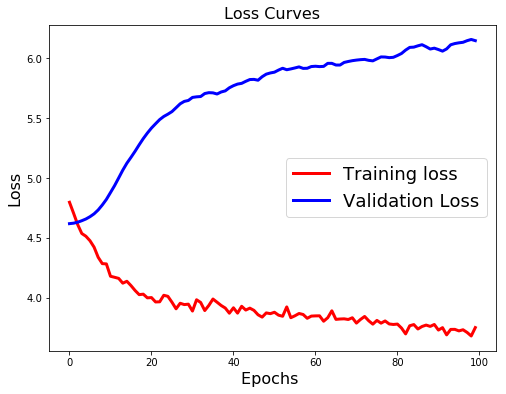

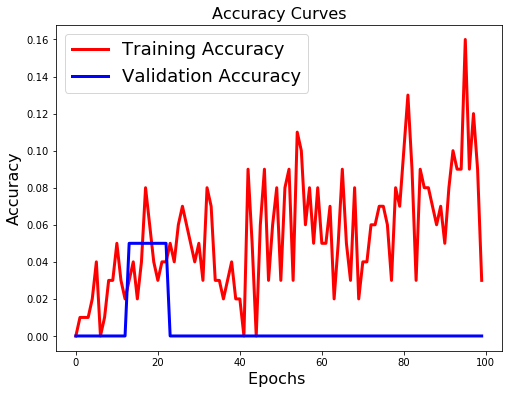

In [380]:
import matplotlib.pyplot as plt
%matplotlib inline
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [231]:
print (metrics.val_f1s)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### One Hot Encoding Experiment:

In [394]:
from sklearn.preprocessing import OneHotEncoder

In [418]:
enc = OneHotEncoder()
enc.fit([[1], [2], [3], [5]])  

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [419]:
enc.n_values_

array([6])

In [420]:
enc.feature_indices_

array([0, 6])

In [423]:
enc.transform([[3]]).toarray()

array([[ 0.,  0.,  1.,  0.]])

In [429]:
y_train_list = [1,2,3,99]
one_hot_train = np.zeros((len(y_train_list),100))
for i in range(0,len(y_train_list)):
    one_hot_train[i][y_train_list[i]]=1
one_hot_train

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

In [6]:
f1

0.26666666666666666

In [13]:
precision = 0.588164

In [12]:
recall = 0.287766

In [14]:
2 * (precision * recall ) /  (precision + recall)

0.38645462907766603

In [19]:
import numpy as np
list_ = [2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8,2,3,10,19,1,1,2,3,4,4,6,7,8]
np.array(list_)

array([ 2,  3, 10, 19,  1,  1,  2,  3,  4,  4,  6,  7,  8,  2,  3, 10, 19,
        1,  1,  2,  3,  4,  4,  6,  7,  8,  2,  3, 10, 19,  1,  1,  2,  3,
        4,  4,  6,  7,  8,  2,  3, 10, 19,  1,  1,  2,  3,  4,  4,  6,  7,
        8,  2,  3, 10, 19,  1,  1,  2,  3,  4,  4,  6,  7,  8,  2,  3, 10,
       19,  1,  1,  2,  3,  4,  4,  6,  7,  8,  2,  3, 10, 19,  1,  1,  2,
        3,  4,  4,  6,  7,  8,  2,  3, 10, 19,  1,  1,  2,  3,  4,  4,  6,
        7,  8,  2,  3, 10, 19,  1,  1,  2,  3,  4,  4,  6,  7,  8,  2,  3,
       10, 19,  1,  1,  2,  3,  4,  4,  6,  7,  8,  2,  3, 10, 19,  1,  1,
        2,  3,  4,  4,  6,  7,  8,  2,  3, 10, 19,  1,  1,  2,  3,  4,  4,
        6,  7,  8,  2,  3, 10, 19,  1,  1,  2,  3,  4,  4,  6,  7,  8,  2,
        3, 10, 19,  1,  1,  2,  3,  4,  4,  6,  7,  8,  2,  3, 10, 19,  1,
        1,  2,  3,  4,  4,  6,  7,  8,  2,  3, 10, 19,  1,  1,  2,  3,  4,
        4,  6,  7,  8,  2,  3, 10, 19,  1,  1,  2,  3,  4,  4,  6,  7,  8,
        2,  3, 10, 19,  1